In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor

In [2]:
path = 'Funda_dataset_cleaned.csv'
data = pd.read_csv(path)

In [3]:
data.shape

(6007, 112)

In [ ]:
print(data.dtypes.unique())

[dtype('O') dtype('int64')]


In [5]:

num_duplicates = data.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)
data.drop_duplicates(inplace=True)

Number of duplicate rows: 13


# Drop time variables

In [6]:
data.drop(['Aangeboden sinds', 'Verkoopdatum'], axis=1, inplace=True)

In [7]:
data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')

<ipython-input-7-855a70a2f4ab>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')


Woonruimte in m2                            0.668535
Inhoud in m3                                0.553106
Bathrooms                                   0.465577
Vraagprijs per m2                           0.449933
Aantal kamers                               0.382853
                                              ...   
Voorzieningen_Tvkabel                      -0.082148
Schuur/berging_Vrijstaandestenen berging   -0.097014
Verwarming_Blokverwarming                  -0.127547
Voorzieningen_Satellietschotel                   NaN
Voorzieningen_cctv                               NaN
Name: Laatste vraagprijs, Length: 103, dtype: float64

In [8]:
cor=data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')

<ipython-input-8-1875e60eb14e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor=data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')


# Drop less than 0.1 correlated

<ipython-input-9-1bfcd880fecc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()
<ipython-input-9-1bfcd880fecc>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
<ipython-input-9-1bfcd880fecc>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to

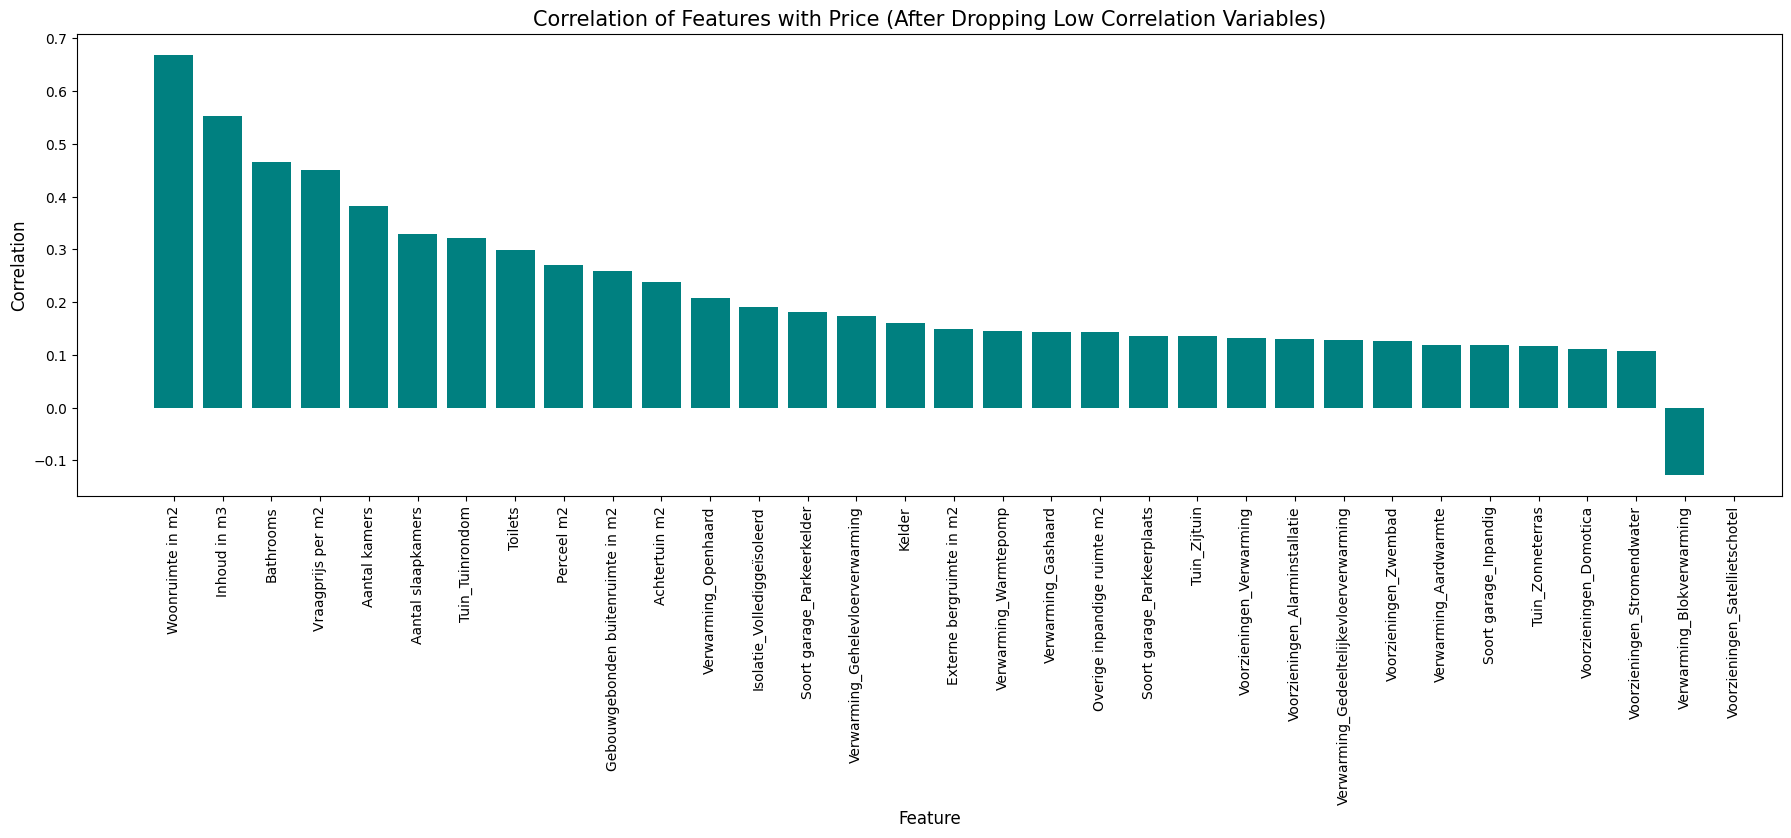

In [9]:
#correlation matrix
corr_matrix = data.corr()

drop_list = corr_matrix[corr_matrix['Laatste vraagprijs'].abs() < 0.1].index.to_list()
data = data.drop(drop_list, axis=1)

plt.figure(figsize=(22,6))
plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Price (After Dropping Low Correlation Variables)', fontsize=15)
plt.show()

In [10]:
data.shape

(5994, 41)

# **Split the Target variable from the input variables**

In [11]:
X = data.drop('Laatste vraagprijs',axis=1)
y = data['Laatste vraagprijs']

X.head()
X.describe()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5994 entries, 0 to 6006
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Status                                   5994 non-null   object 
 1   Soort bouw                               5994 non-null   object 
 2   Aantal kamers                            5994 non-null   int64  
 3   Energielabel                             5994 non-null   object 
 4   Overige inpandige ruimte m2              5994 non-null   int64  
 5   Perceel m2                               5994 non-null   int64  
 6   Achtertuin m2                            5994 non-null   int64  
 7   Aantal dagen tot verkoop                 5994 non-null   object 
 8   Vraagprijs per m2                        5994 non-null   int64  
 9   Woonruimte in m2                         5994 non-null   int64  
 10  Gebouwgebonden buitenruimte in m2        5994 no

# **Split the data into Train and Test**

In [12]:
#training and testing sets
X_train_full, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Scaling and Encoding


In [13]:
from sklearn.preprocessing import StandardScaler

# transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_col = [col for col in X_train_full.columns if X_train_full[col].dtype == 'O' and X_train_full[col].nunique() < 1000]

print("Categorical Columns:")
print(categorical_col)

# numerical columns
numerical_col = [col for col in X_train_full.columns if X_train_full[col].dtype in ['float64', 'int64']]

print("Numerical Columns:")
print(numerical_col)


my_cols = categorical_col + numerical_col

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)])

eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

Categorical Columns:
['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis']
Numerical Columns:
['Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2', 'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2', 'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica', 'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Alarminstallatie', 'Voorzieningen_Satellietschotel', 'Voorzieningen_cctv', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming', 'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Aardwarmte', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard', 'Verwarming_Openhaard', 'Tuin_Zijtuin', 'Tuin_Tuinrondom', 'Tuin_Zonneterras', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder']


In [15]:
# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
 ('cat', categorical_transformer, categorical_col)])


eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

In [16]:

# Transform X_train and X_test without eval_set_pipe
X_train_eval = X_train_full[my_cols]
X_test_eval = X_test[my_cols]

# Convert the original data to DataFrames with the original index (no transformation)
X_train_eval_df = pd.DataFrame(X_train_eval, index=X_train_full.index)
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)
X_test_eval_df.head()

,Status,Soort bouw,Energielabel,Aantal dagen tot verkoop,Soort dak,Soort woonhuis,Aantal kamers,Overige inpandige ruimte m2,Perceel m2,Achtertuin m2,...,Verwarming_Aardwarmte,Verwarming_Blokverwarming,Verwarming_Gashaard,Verwarming_Openhaard,Tuin_Zijtuin,Tuin_Tuinrondom,Tuin_Zonneterras,Soort garage_Parkeerplaats,Soort garage_Inpandig,Soort garage_Parkeerkelder
5741,Verkocht,Bestaande bouw,A++,3 days,Plat dak bedekt met bitumineuze dakbedekking,"Bungalow, geschakelde woning (semi-bungalow)",4,0,255,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2167,Verkocht,Bestaande bouw,B,17 days,Plat dak bedekt met bitumineuze dakbedekking,"Eengezinswoning, tussenwoning",4,0,148,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2419,Verkocht,Bestaande bouw,B,30 days,Plat dak bedekt met bitumineuze dakbedekking,"Eengezinswoning, geschakelde woning",4,0,109,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483,Verkocht,Nieuwbouw,None,71 days,Plat dak bedekt met bitumineuze dakbedekking,"Herenhuis, 2-onder-1-kapwoning",2,0,37,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1382,Verkocht,Bestaande bouw,D,12 days,Zadeldak bedekt met pannen,"Eengezinswoning, 2-onder-1-kapwoning",6,8,243,95,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:

column_names_df = pd.DataFrame([X_train_full[my_cols].columns])

# X_train and X_test using eval_set_pipe transformation
X_train_eval = eval_set_pipe.fit_transform(X_train_full[my_cols])
X_test_eval = eval_set_pipe.transform(X_test[my_cols])


X_train_eval_df = pd.DataFrame(X_train_eval, index=X_train_full.index)
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)
X_test_eval_df

,0
5741,"(0, 0)\t-0.5\n (0, 2)\t0.6204819277108434\n..."
2167,"(0, 0)\t-0.5\n (0, 2)\t-0.02409638554216867..."
2419,"(0, 0)\t-0.5\n (0, 2)\t-0.25903614457831325..."
483,"(0, 0)\t-1.5\n (0, 2)\t-0.6927710843373494\..."
1382,"(0, 0)\t0.5\n (0, 1)\t0.8888888888888888\n ..."
...,...
819,"(0, 2)\t0.006024096385542169\n (0, 3)\t0.20..."
4163,"(0, 2)\t-0.15060240963855423\n (0, 3)\t-0.1..."
2115,"(0, 0)\t-0.5\n (0, 1)\t2.111111111111111\n ..."
1603,"(0, 0)\t-1.0\n (0, 2)\t-0.5180722891566265\..."


In [18]:
my_model_adaboost = AdaBoostRegressor(n_estimators=1500, learning_rate=0.001, loss='exponential', random_state=60)

In [19]:

X_train_eval = eval_set_pipe.fit_transform(X_train_full[my_cols])
X_test_eval = eval_set_pipe.transform(X_test[my_cols])

# change to numeric variable
y_train_numeric = y_train.astype('float')

# Train
my_model_adaboost.fit(X_train_eval, y_train_numeric)

#  test set
y_test_pred_adaboost = my_model_adaboost.predict(X_test_eval)

In [ ]:

mse = mean_squared_error(y_test, y_test_pred_adaboost)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred_adaboost)


mape = np.mean(np.abs((y_test - y_test_pred_adaboost) / y_test)) * 100

from sklearn import metrics
print('R2 Score_XGBoost Regression=',metrics.r2_score(y_test, y_test_pred_adaboost))


print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")


R2 Score_XGBoost Regression= 0.7876634724328913
Mean Squared Error (MSE): 9196949675.978456
Root Mean Squared Error (RMSE): 95900.72823487033
Mean Absolute Error (MAE): 62828.008955151476
Mean Absolute Percentage Error (MAPE): 16.458716686843754 %


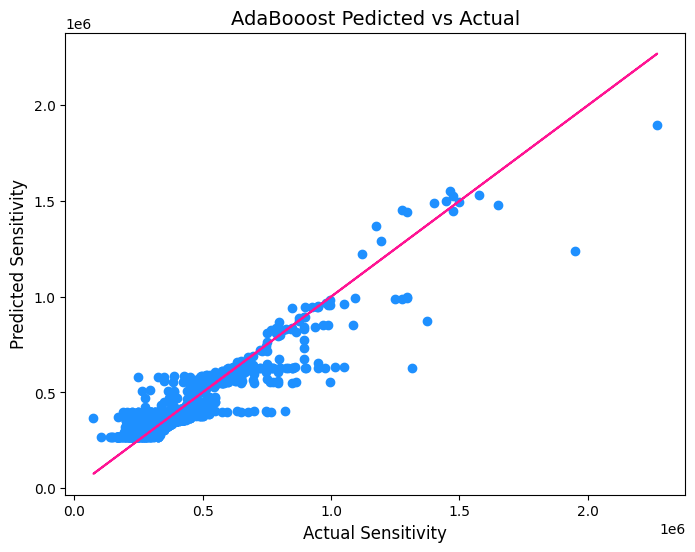

In [20]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8,6))
plt.scatter(x=y_test, y=y_test_pred_adaboost , color='dodgerblue')

# 45-degree line to represent the perfect prediction
plt.plot(y_test,y_test, color='deeppink')


plt.xlabel('Actual Sensitivity',fontsize=12)
plt.ylabel('Predicted Sensitivity',fontsize=12)
plt.title('AdaBooost Pedicted vs Actual',fontsize=14)

# Display the plot
plt.show()

In [ ]:
# Transform X_test using eval_set_pipe
X_test_eval = eval_set_pipe.transform(X_test.copy())

# Convert the transformed data to a DataFrame with the original index
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)

# predictions on the test set using the transformed data
pred_test = my_model_adaboost.predict(X_test_eval)


predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred_adaboost})


print(predictions_df.head())

      Actual      Predicted
6209  369000  540132.006757
343   525000  395756.891045
9788  420000  403541.787879
3056  350000  345710.254167
6513  235000  263155.594519


In [ ]:
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



#log transformation
data['Laatste vraagprijs_log'] = np.log1p(data['Laatste vraagprijs'].dropna())

# the AdaBoostRegressor model
my_model_adaboost = AdaBoostRegressor(n_estimators=1500, learning_rate=0.01)

param_grid_adaboost = {
    'n_estimators': range(50, 5000, 100),
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
}


start_time_adaboost = time.time()


random_search_adaboost = RandomizedSearchCV(my_model_adaboost, param_grid_adaboost, cv=5, scoring='neg_mean_squared_error', n_iter=5)



# Fit the RandomizedSearchCV object to the training data
random_search_adaboost.fit(X_train_eval, y_train_numeric)

# Get the best model from the RandomizedSearchCV object
best_model_adaboost = random_search_adaboost.best_estimator_


best_model_adaboost.fit(X_train_eval, y_train_numeric)

# Calculate the time it took to train the AdaBoost model
training_time_adaboost = time.time() - start_time_adaboost

# Calculate the time left to finish the code to run in percentage
time_left_percentage_adaboost = (100 - (training_time_adaboost / (training_time_adaboost + 1))) * 100

# Print the time it took to train the AdaBoost model and the time left in percentage
print("Training time (AdaBoost):", training_time_adaboost)
print("Time left in percentage (AdaBoost):", time_left_percentage_adaboost)

# Make predictions on the test set with the best AdaBoost model
y_test_pred_adaboost = best_model_adaboost.predict(X_test_eval)

In [ ]:

from sklearn import metrics
print('R2 Score_ADABoost Regression=',metrics.r2_score(y_test,y_test_pred))


# Print the accuracy measures
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from scipy.stats import uniform

# Transform X_train and X_test using eval_set_pipe
X_train_eval = eval_set_pipe.fit_transform(X_train_full[my_cols])
X_test_eval = eval_set_pipe.transform(X_test[my_cols])


y_train_numeric = y_train.astype('float')

# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': [100, 500, 1000, 1500],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'loss': ['linear', 'square', 'exponential'],
    'random_state': [10, 42, 123, 456, 600]  # Add random_state values to the parameter grid
}

# Create an AdaBoostRegressor model
base_model = AdaBoostRegressor()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCAV(base_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)


random_search.fit(X_train_eval, y_train_numeric)

# Get the best parameters from the RandomizedSearchCV
best_params = random_search.best_params_


print("Best Parameters:", best_params)


best_model_adaboost = random_search.best_estimator_


y_test_pred_adaboost = best_model_adaboost.predict(X_test_eval)

Best Parameters: {'random_state': 123, 'n_estimators': 1000, 'loss': 'square', 'learning_rate': 0.1}
